In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import re
from collections import Counter

# VEST OH 2020
---

## VEST Documentation

### Election Results

#### Sources
Election results from the Ohio Secretary of State (https://www.sos.state.oh.us/elections/election-results-and-data/). 

#### Processing Part 1
The following counties include adjustments to account for corporate annexations that are not specified below by precinct: Adams, Athens, Butler, Franklin, Guernsey, Montgomery, Stark, Tuscarawas, Warren, Wayne.

#### Processing Part 2 (unclear whether this is for election results, shapefiles, or both)
The following additional revisions were made to match the 2020 precinct boundaries:

- **Athens:** Adjust Athens 4-4/4-5, Nelsonville 1/2/3/4
- **Brown:** Adjust Perry Twp South/Villages
- **Butler:** Adjust Hamilton 22/24, Oxford 6/11, Trenton 5/7, West Chester 28/39
- **Champaign:** Adjust Union N/S
- **Clark:** Align New Carlisle, Springfield precincts with county maps
- **Crawford:** Move eastern Polk Twp from Galion 1B to western Polk Twp
- **Cuyahoga:** Adjust Olmsted Twp D/F/H
- **Delaware:** Adjust Berlin C/Delaware 3-F
- **Fairfield:** Adjust Greenfield B/Lancaster 2-A, Pickerington F/Violet B/Violet C
- **Greene:** Adjust Bath 277/Fairborn 226/Xenia 351
- **Hamilton:** Adjust Cleves A/Whitewater A, Colerain BB/F
- **Knox:** Adjust Clinton A/Mount Vernon 1-B, Clinton B/Mount Vernon 2-A
- **Lake:** Adjust Painesville A/K
- **Medina:** Adjust Wadsworth City 1-D/Sharon D, Wadsworth City 2-D/Twp C
- **Richland:** Adjust Ontario 3/4
- **Stark:** Adjust Canton 8-C/Plain 6, Canton 6-A/Plain 12
- **Summit:** Adjust Coventry D/G, Hudson 1-B/3-C, Springfield F/J
- **Warren:** Adjust Mason City Z/Union A, South Lebanon A/B

#### Races
G20PRERTRU - Donald J. Trump (Republican Party)  
G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  
G20PREGHAW - Howie Hawkins (Independent)  

### Shapefiles

#### Sources
Precinct shapefile from the U.S. Census Bureau's 2020 Redistricting Data Program final release. Note that some VTDs were relabeled to match precinct names and/or precinct codes in the November 2020 general election returns.

# Election Result Processing

## Get VEST file and FIPS dictionary ready

### Load in VEST file

In [2]:
vest_oh_20 = gp.read_file("./raw-from-source/VEST/oh_2020/oh_2020.shp")

In [3]:
vest_oh_20.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<AxesSubplot:>

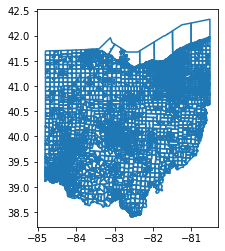

In [4]:
vest_oh_20.boundary.plot()

In [5]:
vest_oh_20.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW', 'geometry'],
      dtype='object')

### Create a FIPs dictionary for OH

In [6]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Ohio"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
oh_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

## Load and Clean Election Results

### Load Election Results

Cleaned the `statewideresultsbyprecinct.xlsx` file by hand, and created `statewideresultsbyprecinct_clean.csv`. No modifications were made to the election results. Unnecessary tabs were removed and column names were renamed to match VEST's manually. 

In [7]:
#Load in clean SOS file
dem_elections_2020 = pd.read_excel("./raw-from-source/SOS/democratprecinctall.xlsx",sheet_name="Master")
rep_elections_2020 = pd.read_excel("./raw-from-source/SOS/republicanprecinct.xlsx",sheet_name="Master")
lib_elections_2020 = pd.read_excel("./raw-from-source/SOS/libertarianprecinctall.xlsx",sheet_name="Master")

In [8]:
dem_elections_2020.head()

,"March 17, 2020 Primary Election Official Canvass\n*Results for write-in (WI) candidates will not be available on election night.\n*Write-in candidates will be displayed with a (WI) designation and not party affiliation.\n*Precinct-level data is not available for write-in candidates. To view results for write-in candidates, download the Summary-level spreadsheet.",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,President (at-large)\n,Unnamed: 9,...,State Representative - District 88\n,State Representative - District 89\n,State Representative - District 91\n,State Representative - District 92\n,State Representative - District 94\n,State Representative - District 96\n,Unnamed: 193,State Representative - District 97\n,State Representative - District 98\n,State Representative - District 99\n
0,County Name,Precinct Name,Precinct Code,Region Name,Media Market,Registered Voters,Total Voters,Turnout Percentage,Michael Bennet (D),Joseph R. Biden Jr (D),...,Chris Liebold (D),Alexis Miller (D),Scott M. Dailey (D),Beth Workman (D),Katie O'Neill (D),Charlie DiPalma (D),Richard A. Olivito (D),Alaina Swope (D),Todd E Beegle (D),Richard Dana (D)
1,Total,NaN,NaN,NaN,NaN,7774767,1834465,0.235951,2030,647284,...,5473,7769,3225,4669,5356,4359,5370,4139,4870,5836
2,Percentage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002271,0.724128,...,1,1,1,1,1,0.448042,0.551958,1,1,1
3,Adams,BRATTON TOWNSHIP,AAA,Southwest,Cincinnati,904,241,0.266593,0,42,...,0,0,0,0,0,0,0,0,0,0
4,Adams,BRUSH CREEK TOWNSHIP,AAB,Southwest,Cincinnati,749,183,0.244326,0,36,...,0,0,0,0,0,0,0,0,0,0


In [9]:
def clean_oh_import(dataframe):
    
    corrected_col_names = []
    for index in range(0,len(dataframe.columns)):
        col_name = dataframe.columns[index]
        col_name = col_name.replace("\n"," ")
        if "Unnamed" in col_name:
            corrected_col_names.append(corrected_col_names[index-1])
        else:
            corrected_col_names.append(col_name)
    dataframe.columns = corrected_col_names
    
    corrected_col_names = []
    for index in range(0,len(dataframe.columns)):
        col = dataframe.columns[index]
        first_row = dataframe.iloc[0,index]
        if (index > 7):
            new_column_name = col + " " + first_row 
            corrected_col_names.append(new_column_name)
        else:
            corrected_col_names.append(first_row)
    dataframe.columns = corrected_col_names
    
    dataframe = dataframe.iloc[3:,]
    return dataframe

In [10]:
dem_elections_2020_clean = clean_oh_import(dem_elections_2020)
rep_elections_2020_clean = clean_oh_import(rep_elections_2020)
lib_elections_2020_clean = clean_oh_import(lib_elections_2020)

In [11]:
for val in [dem_elections_2020_clean,rep_elections_2020_clean,lib_elections_2020_clean]:
    print(val.shape)
    val["UNIQUE_ID"] = val["County Name"]+"-"+val["Precinct Code"]

(8933, 197)
(8933, 226)
(8933, 15)


<ipython-input-11-e60a347620bc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val["UNIQUE_ID"] = val["County Name"]+"-"+val["Precinct Code"]


In [12]:
col_check_1 = rep_elections_2020_clean["UNIQUE_ID"] == lib_elections_2020_clean["UNIQUE_ID"]
col_check_2 = lib_elections_2020_clean["UNIQUE_ID"] == dem_elections_2020_clean["UNIQUE_ID"]

In [13]:
rep_elections_2020_clean.columns

Index(['County Name', 'Precinct Name', 'Precinct Code', 'Region Name',
       'Media Market', 'Registered Voters', 'Total Voters',
       'Turnout Percentage', 'President (at-large)  Donald J. Trump (R)',
       'President (district) - District 01  Donald J. Trump (R)',
       ...
       'State Representative - District 92  Mark Johnson (R)',
       'State Representative - District 93  Jeff Halley (R)',
       'State Representative - District 93  Jason C. Stephens (R)',
       'State Representative - District 94  Jay Edwards (R)',
       'State Representative - District 95  Don Jones (R)',
       'State Representative - District 96  Ron Ferguson (R)',
       'State Representative - District 97  Adam Holmes (R)',
       'State Representative - District 98  Brett Hudson Hillyer (R)',
       'State Representative - District 99  Sarah E. Fowler (R)', 'UNIQUE_ID'],
      dtype='object', length=227)

In [14]:
rep_elections_2020_clean.drop(['County Name', 'Precinct Name', 'Precinct Code', 'Region Name','Media Market', 'Registered Voters','Total Voters','Turnout Percentage',"UNIQUE_ID"],inplace=True,axis=1)
lib_elections_2020_clean.drop(['County Name', 'Precinct Name', 'Precinct Code', 'Region Name','Media Market', 'Registered Voters','Total Voters','Turnout Percentage',"UNIQUE_ID"],inplace=True,axis=1)

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [15]:
combined = pd.concat([dem_elections_2020_clean,rep_elections_2020_clean,lib_elections_2020_clean],axis=1)

In [16]:
elections_2020 = combined.copy(deep=True)

In [17]:
elections_2020.drop("UNIQUE_ID", axis=1 , inplace=True)

In [18]:
#Map to the correct FIP
elections_2020["COUNTYFP"]=elections_2020["County Name"].map(oh_fips_dict).fillna(elections_2020["County Name"])

#Print out the FIPS to make sure they all are in the correct format
elections_2020["COUNTYFP"].unique()

array(['001', '003', '005', '007', '009', '011', '013', '015', '017',
       '019', '021', '023', '025', '027', '029', '031', '033', '035',
       '037', '039', '041', '043', '045', '047', '049', '051', '053',
       '055', '057', '059', '061', '063', '065', '067', '069', '071',
       '073', '075', '077', '079', '081', '083', '085', '087', '089',
       '091', '093', '095', '097', '099', '101', '103', '105', '107',
       '109', '111', '113', '115', '117', '119', '121', '123', '125',
       '127', '129', '131', '133', '135', '137', '139', '141', '143',
       '145', '147', '149', '151', '153', '155', '157', '159', '161',
       '163', '165', '167', '169', '171', '173', '175'], dtype=object)

In [19]:
filter_out_cols = [i for i in elections_2020.columns if ("Judge of the Court of Appeals - District" in i or "Member of the State Board of Education - District" in i or "WI" in i)]


In [20]:
elections_2020 = elections_2020[[i for i in elections_2020.columns if i not in filter_out_cols]]

## Look into split precincts

In [21]:
def get_level_dist(column_name):
    if "Representative to Congress" in column_name:
        level = "CON"
    elif "State Senator" in column_name:
        level = "SU"
    elif "State Representative" in column_name:
        level = "SL"
    else:
        raise ValueError
    return_val = re.findall("District \S{2}",column_name)    
    if (len(return_val)!=0):
        dist = return_val[0].split(" ")[1]
    else:
        raise ValueError
    return level,dist

In [22]:
def is_split_precinct(district_assignment_list):
    c = Counter([x[0] for x in district_assignment_list])
    greater_than_one = {x:[y[1] for y in district_assignment_list if y[0]==x] for x, count in c.items() if count > 1}
    if len(greater_than_one)==0:
        return 0
    else:
        return greater_than_one

In [23]:
for col in elections_2020[[i for i in elections_2020.columns if "President (district)" in i]]:
    print(col)
    print(sum(elections_2020[[i for i in elections_2020.columns if "President" in i]][col]))

President (district) - District 01  Donald J. Trump (R)
45125
President (district) - District 02  Donald J. Trump (R)
52981
President (district) - District 03  Donald J. Trump (R)
12971
President (district) - District 04  Donald J. Trump (R)
63283
President (district) - District 05  Donald J. Trump (R)
56297
President (district) - District 06  Donald J. Trump (R)
62299
President (district) - District 07  Donald J. Trump (R)
54886
President (district) - District 08  Donald J. Trump (R)
56470
President (district) - District 09  Donald J. Trump (R)
18095
President (district) - District 10  Donald J. Trump (R)
47061
President (district) - District 11  Donald J. Trump (R)
10116
President (district) - District 12  Donald J. Trump (R)
56368
President (district) - District 13  Donald J. Trump (R)
29243
President (district) - District 14  Donald J. Trump (R)
49125
President (district) - District 15  Donald J. Trump (R)
43236
President (district) - District 16  Donald J. Trump (R)
43543


In [24]:
#Combine the republican presidential primary results into one column
elections_2020["President Donald J. Trump (R)"] = 0
for val in [i for i in elections_2020.columns if "President (district)" in i]:
    elections_2020["President Donald J. Trump (R)"] += elections_2020[val]

In [25]:
elections_2020.drop([i for i in elections_2020.columns if "President (district)" in i],axis=1,inplace=True)

In [26]:
district_cols = [i for i in elections_2020.columns if "District" in i]
elections_2020_districts = elections_2020[['COUNTYFP','Precinct Name','Precinct Code']+district_cols]

In [27]:
district_cols

['Representative to Congress - District 01  Nikki Foster (D)',
 'Representative to Congress - District 01  Kate Schroder (D)',
 'Representative to Congress - District 02  Jaime M. Castle (D)',
 'Representative to Congress - District 03  Joyce Beatty (D)',
 'Representative to Congress - District 03  Morgan Harper (D)',
 'Representative to Congress - District 04  Shannon M. Freshour (D)',
 'Representative to Congress - District 04  Mike Larsen (D)',
 'Representative to Congress - District 04  Jeffrey A. Sites (D)',
 'Representative to Congress - District 05  M. Xavier Carrigan (D)',
 'Representative to Congress - District 05  Gene Redinger (D)',
 'Representative to Congress - District 05  Nick Rubando (D)',
 'Representative to Congress - District 06  Shawna Roberts (D)',
 'Representative to Congress - District 08  Vanessa Enoch (D)',
 'Representative to Congress - District 08  Matt Guyette (D)',
 'Representative to Congress - District 09  Marcy Kaptur (D)',
 'Representative to Congress -

In [28]:
precinct_mapping_dict = {}
split_precincts_list = {}
for index,row in elections_2020_districts.iterrows():
    precinct_list = []
    for contest in district_cols:
        if(row[contest]!=0):
            precinct_info = get_level_dist(contest)
            if precinct_info not in precinct_list:
                precinct_list.append(get_level_dist(contest))
    is_split = is_split_precinct(precinct_list)
    if (is_split):
        split_precincts_list[row["COUNTYFP"]+"-"+row["Precinct Code"]]=is_split
    precinct_mapping_dict[row["COUNTYFP"]+"-"+row["Precinct Code"]]=precinct_list

## Rename the columns

In [29]:
list(elections_2020.columns)

['County Name',
 'Precinct Name',
 'Precinct Code',
 'Region Name',
 'Media Market',
 'Registered Voters',
 'Total Voters',
 'Turnout Percentage',
 'President (at-large)  Michael Bennet (D)',
 'President (at-large)  Joseph R. Biden Jr (D)',
 'President (at-large)  Michael R.  Bloomberg (D)',
 'President (at-large)  Pete Buttigieg (D)',
 'President (at-large)  Tulsi Gabbard (D)',
 'President (at-large)  Amy  Klobuchar (D)',
 'President (at-large)  Deval Patrick (D)',
 'President (at-large)  Bernie Sanders (D)',
 'President (at-large)  Tom Steyer (D)',
 'President (at-large)  Elizabeth Warren (D)',
 'Representative to Congress - District 01  Nikki Foster (D)',
 'Representative to Congress - District 01  Kate Schroder (D)',
 'Representative to Congress - District 02  Jaime M. Castle (D)',
 'Representative to Congress - District 03  Joyce Beatty (D)',
 'Representative to Congress - District 03  Morgan Harper (D)',
 'Representative to Congress - District 04  Shannon M. Freshour (D)',
 'Repr

## Rename Columns

In [30]:
elections_2020.columns

keep_names = ['County Name','Precinct Name','Precinct Code','Region Name','Media Market','Registered Voters','Ballots Counted','Official Voter Turnout','Total Voters','Turnout Percentage','COUNTYFP','UNIQUE_ID']

In [31]:
def get_race(contest):
    if "Justice of the Supreme Court" in contest:
        level = "SSC"
        if "Kennedy" in contest or "O'Donnell" in contest:
            level = "SSCK"
        else:
            level = "SSCF"
    elif "President" in contest:
        level = "PRE"
    elif ("Representative to Congress" in contest or "State Senator" in contest or "State Representative" in contest):
        contest_info = get_level_dist(contest)
        level = contest_info[0]+contest_info[1]
    else:
          raise ValueError
    return level

In [32]:
def get_party(contest):
    if contest == "State Representative - District 30  Tom Roll":
        return "I"
    if "Justice of the Supreme Court Term" in contest:
        if "Sharon L. Kennedy" in contest:
            return "R"
        elif "John P. O'Donnell" in contest:
            return "D"
        elif "Jennifer Brunner" in contest:
            return "D"
        elif "Judi French" in contest:
            return "R"
        else:
            print(contest)
            raise ValueError
    return_val = re.findall("\(\S\)",contest)   
    if (len(return_val)!=0):
        party = return_val[0][1]
        return party
    else:
        print(contest)
        raise ValueError

In [33]:
def get_name(contest):
    contest = contest.upper()
    contest = contest.replace("'","")
    if ("(") in contest.split(" ")[-1]:
        second_to_last = contest.split(" ")[-2]
        #second_to_last = second_to_last.replace("'","")
        if second_to_last in ["JR","III"]:
            third_to_last = contest.split(" ")[-3]
            #third_to_last = third_to_last.replace("'","")
            return third_to_last[0:3]
        else:
            return second_to_last[0:3]
    else:
        return contest.split(" ")[-1][0:3] 

In [34]:
elections_2020.drop('President Donald J. Trump (R)',axis=1,inplace=True)

In [35]:
contest_name_change_dict = {}
for contest in elections_2020.columns:
    if contest  not in keep_names or "President" in contest:
        contest_name_change_dict[contest] = "P"+get_race(contest)+get_party(contest)+get_name(contest)

In [36]:
contest_name_change_dict['Representative to Congress - District 13  Richard A. Morckel (R)'] = 'PCON13RRMO'
contest_name_change_dict['Representative to Congress - District 13  Jason Mormando (R)'] = 'PCON13RJMO'

In [37]:
df = pd.DataFrame([(v, k) for k, v in contest_name_change_dict.items()], columns=['Candidate', 'Column'])
# Store the data into a csv file

if not os.path.exists('./cand_dicts/'):
    os.mkdir('./cand_dicts/')

df.to_csv('./cand_dicts/oh_prim_20_cong_prec.csv', sep=',')

In [38]:
len(list(contest_name_change_dict.values()))

343

In [39]:
len(set(contest_name_change_dict.values()))

343

In [40]:
elections_2020.rename(columns=contest_name_change_dict,inplace=True)

### Filter Down to Relevant Columns


In [41]:
keeper_columns = ['County Name','Precinct Name','Precinct Code','Region Name','Media Market','Registered Voters','COUNTYFP']
us_house_contests = [i for i in list(elections_2020.columns) if "PCON" in i]

In [42]:
elections_2020 = elections_2020[keeper_columns+us_house_contests]

### Compare Precinct Totals

In [43]:
elections_2020["UNIQUE_ID"] = elections_2020["COUNTYFP"]+"-"+elections_2020["Precinct Code"]
vest_oh_20["UNIQUE_ID"] = vest_oh_20["COUNTYFP20"]+"-"+vest_oh_20["PRECINCT20"]

In [44]:
#Confirm unique IDs are unique
print(elections_2020["UNIQUE_ID"].value_counts(dropna=False))
print(vest_oh_20["UNIQUE_ID"].value_counts(dropna=False))

049-AYI    1
049-BHJ    1
049-APN    1
077-ACG    1
081-ADM    1
          ..
035-AGH    1
099-AKV    1
035-CQB    1
093-AAW    1
169-ACX    1
Name: UNIQUE_ID, Length: 8933, dtype: int64
049-AYI    1
077-ABC    1
077-ACM    1
087-ADB    1
153-AVN    1
          ..
095-AWA    1
169-AAA    1
101-AAU    1
035-BHV    1
057-ABG    1
Name: UNIQUE_ID, Length: 8941, dtype: int64


In [45]:
global attempt_one
attempt_one = pd.merge(vest_oh_20,elections_2020,how="outer",on="UNIQUE_ID",indicator=True)
print(attempt_one["_merge"].value_counts())

vest_only = attempt_one[attempt_one["_merge"]=="left_only"]
elections_only = attempt_one[attempt_one["_merge"]=="right_only"]

both          8933
left_only        8
right_only       0
Name: _merge, dtype: int64


In [46]:
#Confirm these are all zero-vote races
races =["UNIQUE_ID"]

for val in ['G20PRERTRU', 'G20PREDBID', 'G20PRELJOR',
       'G20PREGHAW']:
    races.append(val)

print((vest_only[races]))

     UNIQUE_ID  G20PRERTRU  G20PREDBID  G20PRELJOR  G20PREGHAW
814    093-ZZZ           0           0           0           0
982    123-ZZZ           0           0           0           0
2924   095-ZZZ           0           0           0           0
3674   043-ZZZ           0           0           0           0
4389   085-ZZZ           0           0           0           0
4565   035-ZZZ           0           0           0           0
5357   133-ZZZ           0           0           0           0
7951   007-ZZZ           0           0           0           0


## Perform Splits

In [47]:
def return_con_splits(split_dict):
    for val in split_dict.keys():
        if 'CON' in val:
            return split_dict['CON']

In [48]:
con_splits_dict = {i:return_con_splits(split_precincts_list[i]) for i in split_precincts_list.keys() if return_con_splits(split_precincts_list[i]) != None }

#### Create dictionary of where the splits should occur

#### Load in the shapefile

In [49]:
oh_con_districts = gp.read_file("./raw-from-source/District_Shapefiles/oh_pl2020_cd/oh_pl2020_cd.shp")

In [50]:
oh_con_districts.drop(['STATEFP20', 'GEOID20'], axis = 1, inplace = True)

In [51]:
attempt_one.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW', 'geometry',
       'UNIQUE_ID', 'County Name', 'Precinct Name', 'Precinct Code',
       'Region Name', 'Media Market', 'Registered Voters', 'COUNTYFP',
       'PCON01DFOS', 'PCON01DSCH', 'PCON02DCAS', 'PCON03DBEA', 'PCON03DHAR',
       'PCON04DFRE', 'PCON04DLAR', 'PCON04DSIT', 'PCON05DCAR', 'PCON05DRED',
       'PCON05DRUB', 'PCON06DROB', 'PCON08DENO', 'PCON08DGUY', 'PCON09DKAP',
       'PCON09DROS', 'PCON10DMOY', 'PCON10DTIM', 'PCON11DBEL', 'PCON11DFUD',
       'PCON11DHOO', 'PCON11DSHA', 'PCON12DBEL', 'PCON12DSHE', 'PCON13DRYA',
       'PCON14DMUE', 'PCON15DKIL', 'PCON15DNEW', 'PCON16DGOD', 'PCON16DKAR',
       'PCON01RCHA', 'PCON02RHAR', 'PCON02RWEN', 'PCON03RDUL', 'PCON03RRIC',
       'PCON04RJOR', 'PCON05RLAT', 'PCON06RJOH', 'PCON06RMOR', 'PCON07RGIB',
       'PCON08RDAV', 'PCON08RMEE', 'PCON09RBAR', 'PCON09RCON', 'PCON09RCOR',
       'PCON

In [52]:
final_races = ['PCON01DFOS', 'PCON01DSCH', 'PCON02DCAS', 'PCON03DBEA', 'PCON03DHAR',
       'PCON04DFRE', 'PCON04DLAR', 'PCON04DSIT', 'PCON05DCAR', 'PCON05DRED',
       'PCON05DRUB', 'PCON06DROB', 'PCON08DENO', 'PCON08DGUY', 'PCON09DKAP',
       'PCON09DROS', 'PCON10DMOY', 'PCON10DTIM', 'PCON11DBEL', 'PCON11DFUD',
       'PCON11DHOO', 'PCON11DSHA', 'PCON12DBEL', 'PCON12DSHE', 'PCON13DRYA',
       'PCON14DMUE', 'PCON15DKIL', 'PCON15DNEW', 'PCON16DGOD', 'PCON16DKAR',
       'PCON01RCHA', 'PCON02RHAR', 'PCON02RWEN', 'PCON03RDUL', 'PCON03RRIC',
       'PCON04RJOR', 'PCON05RLAT', 'PCON06RJOH', 'PCON06RMOR', 'PCON07RGIB',
       'PCON08RDAV', 'PCON08RMEE', 'PCON09RBAR', 'PCON09RCON', 'PCON09RCOR',
       'PCON09RWEB', 'PCON10RAND', 'PCON10RFLA', 'PCON10RTUR', 'PCON11RGOR',
       'PCON11RSCH', 'PCON11RTAY', 'PCON12RBAL', 'PCON12RDAY', 'PCON13RHAG',
       'PCON13RHEN', 'PCON13RLYR', 'PCON13RRMO', 'PCON13RJMO', 'PCON13RSAN',
       'PCON13RTRU', 'PCON14RJOY', 'PCON14RPIT', 'PCON15RHUN', 'PCON15RSTI',
       'PCON16RGON', 'PCON01LKAH', 'PCON04LPER', 'PCON07LLAP', 'PCON13LFRI']

In [53]:
for val in final_races:
    attempt_one[val] = attempt_one[val].fillna(0)
    attempt_one[val] = attempt_one[val].astype(int)
    print(val, sum(attempt_one[val]))

PCON01DFOS 17520
PCON01DSCH 36579
PCON02DCAS 40956
PCON03DBEA 44995
PCON03DHAR 21057
PCON04DFRE 18078
PCON04DLAR 8944
PCON04DSIT 11037
PCON05DCAR 7843
PCON05DRED 9079
PCON05DRUB 17902
PCON06DROB 30628
PCON08DENO 24297
PCON08DGUY 6269
PCON09DKAP 52433
PCON09DROS 5370
PCON10DMOY 13846
PCON10DTIM 32388
PCON11DBEL 1963
PCON11DFUD 70379
PCON11DHOO 2641
PCON11DSHA 2813
PCON12DBEL 24263
PCON12DSHE 34103
PCON13DRYA 61813
PCON14DMUE 48107
PCON15DKIL 14916
PCON15DNEW 28503
PCON16DGOD 32024
PCON16DKAR 15244
PCON01RCHA 44746
PCON02RHAR 3326
PCON02RWEN 53674
PCON03RDUL 1797
PCON03RRIC 11451
PCON04RJOR 64695
PCON05RLAT 57537
PCON06RJOH 57790
PCON06RMOR 8721
PCON07RGIB 55009
PCON08RDAV 53542
PCON08RMEE 5125
PCON09RBAR 1376
PCON09RCON 2064
PCON09RCOR 3873
PCON09RWEB 10863
PCON10RAND 4110
PCON10RFLA 2944
PCON10RTUR 44704
PCON11RGOR 4589
PCON11RSCH 4027
PCON11RTAY 1083
PCON12RBAL 51412
PCON12RDAY 9877
PCON13RHAG 19327
PCON13RHEN 1032
PCON13RLYR 3483
PCON13RRMO 763
PCON13RJMO 389
PCON13RSAN 3358
PCON13RT

In [54]:
def cd_splits(cd_list,level,old_name):
    global attempt_one
    full_shape = attempt_one.loc[attempt_one["UNIQUE_ID"]==old_name]
    #print(old_name,"->"," & ".join(new_id_list))
    for index in range(0,len(cd_list)):
        cd = oh_con_districts.loc[oh_con_districts["CD116FP"]==cd_list[index]]
        new_prec = gp.overlay(full_shape, cd, how='intersection',keep_geom_type=True)
        if(new_prec.empty):
            print("***Issue merging SLDL: ",cd_list[index],"and prec:",old_name,"***")
        new_prec = new_prec[list(attempt_one.columns)]
        for column in new_prec:
            if column in final_races and cd_list[index] not in column:
                new_prec.loc[0:,column] = 0 
        new_prec["UNIQUE_ID"]=old_name+"-("+level+"-"+cd_list[index]+")"
        attempt_one=attempt_one.append(new_prec)
        attempt_one.reset_index(drop=True,inplace=True)        
    #Remove the precinct that was split
    attempt_one=attempt_one[attempt_one["UNIQUE_ID"]!=old_name]
    attempt_one.reset_index(drop=True,inplace=True)

In [55]:
for val in attempt_one["UNIQUE_ID"]:
    cd_list = []
    if val in con_splits_dict.keys():
        print(val)
        print(con_splits_dict[val])
        #How we will actually call it
        cd_splits(con_splits_dict[val],"CON",val)

145-ADU
['02', '06']
145-ADT
['06', '02']
141-ACP
['02', '15']
047-AAU
['10', '15']
047-ABK
['10', '15']
103-AAP
['16', '07']
103-ADB
['16', '07']
103-AEX
['16', '07']
103-AFR
['07', '16']
077-ABS
['04', '07']
155-AGK
['13', '14']
043-ACF
['04', '09']
035-AEI
['09', '16']
101-ABX
['04', '12']
101-ABY
['04', '12']
035-BFB
['09', '11']
035-BEH
['09', '11']
139-ABW
['12', '07']
139-ABY
['12', '07']
139-ABX
['12', '07']
119-AAB
['06', '12']
153-BAM
['13', '14']
153-ADT
['11', '13']
153-ADA
['11', '13']
153-ADQ
['11', '13']
153-AZA
['11', '13']
153-ABE
['11', '13']
153-AZH
['11', '13']
153-AZD
['11', '13']
153-AMK
['13', '14']
153-AZM
['11', '13']
153-AIF
['11', '13']
153-AAF
['11', '13']
153-AZN
['11', '13']
153-AKV
['13', '14']
049-AOG
['12', '15']
049-AHA
['03', '15']
049-AXD
['03', '12']
049-AEB
['03', '12']
049-AGZ
['03', '15']
049-ADJ
['03', '12']
049-ATM
['03', '15']
049-AID
['03', '15']
049-BEQ
['03', '15']
049-AZO
['03', '15']
049-AGI
['03', '12']
049-BJL
['03', '15']
049-AKR
['03'

In [56]:
pd.options.display.max_columns = 999

display(attempt_one[attempt_one["UNIQUE_ID"]=="049-AZM-(CON-15)"])
display(attempt_one[attempt_one["UNIQUE_ID"]=="049-AZM-(CON-03)"])

,STATEFP20,COUNTYFP20,VTDST20,PRECINCT20,GEOID20,NAME20,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREGHAW,geometry,UNIQUE_ID,County Name,Precinct Name,Precinct Code,Region Name,Media Market,Registered Voters,COUNTYFP,PCON01DFOS,PCON01DSCH,PCON02DCAS,PCON03DBEA,PCON03DHAR,PCON04DFRE,PCON04DLAR,PCON04DSIT,PCON05DCAR,PCON05DRED,PCON05DRUB,PCON06DROB,PCON08DENO,PCON08DGUY,PCON09DKAP,PCON09DROS,PCON10DMOY,PCON10DTIM,PCON11DBEL,PCON11DFUD,PCON11DHOO,PCON11DSHA,PCON12DBEL,PCON12DSHE,PCON13DRYA,PCON14DMUE,PCON15DKIL,PCON15DNEW,PCON16DGOD,PCON16DKAR,PCON01RCHA,PCON02RHAR,PCON02RWEN,PCON03RDUL,PCON03RRIC,PCON04RJOR,PCON05RLAT,PCON06RJOH,PCON06RMOR,PCON07RGIB,PCON08RDAV,PCON08RMEE,PCON09RBAR,PCON09RCON,PCON09RCOR,PCON09RWEB,PCON10RAND,PCON10RFLA,PCON10RTUR,PCON11RGOR,PCON11RSCH,PCON11RTAY,PCON12RBAL,PCON12RDAY,PCON13RHAG,PCON13RHEN,PCON13RLYR,PCON13RRMO,PCON13RJMO,PCON13RSAN,PCON13RTRU,PCON14RJOY,PCON14RPIT,PCON15RHUN,PCON15RSTI,PCON16RGON,PCON01LKAH,PCON04LPER,PCON07LLAP,PCON13LFRI,_merge
9062,39,049,025AZM,AZM,39049025AZM,JACKSON-A,431,161,7,0,"MULTIPOLYGON (((-83.06169 39.88387, -83.06124 ...",049-AZM-(CON-15),Franklin,JACKSON-A,AZM,Central,Columbus,781,049,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,44,0,0,0,0,0,both


,STATEFP20,COUNTYFP20,VTDST20,PRECINCT20,GEOID20,NAME20,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREGHAW,geometry,UNIQUE_ID,County Name,Precinct Name,Precinct Code,Region Name,Media Market,Registered Voters,COUNTYFP,PCON01DFOS,PCON01DSCH,PCON02DCAS,PCON03DBEA,PCON03DHAR,PCON04DFRE,PCON04DLAR,PCON04DSIT,PCON05DCAR,PCON05DRED,PCON05DRUB,PCON06DROB,PCON08DENO,PCON08DGUY,PCON09DKAP,PCON09DROS,PCON10DMOY,PCON10DTIM,PCON11DBEL,PCON11DFUD,PCON11DHOO,PCON11DSHA,PCON12DBEL,PCON12DSHE,PCON13DRYA,PCON14DMUE,PCON15DKIL,PCON15DNEW,PCON16DGOD,PCON16DKAR,PCON01RCHA,PCON02RHAR,PCON02RWEN,PCON03RDUL,PCON03RRIC,PCON04RJOR,PCON05RLAT,PCON06RJOH,PCON06RMOR,PCON07RGIB,PCON08RDAV,PCON08RMEE,PCON09RBAR,PCON09RCON,PCON09RCOR,PCON09RWEB,PCON10RAND,PCON10RFLA,PCON10RTUR,PCON11RGOR,PCON11RSCH,PCON11RTAY,PCON12RBAL,PCON12RDAY,PCON13RHAG,PCON13RHEN,PCON13RLYR,PCON13RRMO,PCON13RJMO,PCON13RSAN,PCON13RTRU,PCON14RJOY,PCON14RPIT,PCON15RHUN,PCON15RSTI,PCON16RGON,PCON01LKAH,PCON04LPER,PCON07LLAP,PCON13LFRI,_merge
9061,39,049,025AZM,AZM,39049025AZM,JACKSON-A,431,161,7,0,"MULTIPOLYGON (((-83.05161 39.89909, -83.05110 ...",049-AZM-(CON-03),Franklin,JACKSON-A,AZM,Central,Columbus,781,049,0,0,0,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,both


## Check the column totals

In [57]:
tot_sum = 0
for val in final_races:
    print(val, sum(attempt_one[val]))
    tot_sum +=sum(attempt_one[val])

PCON01DFOS 17520
PCON01DSCH 36579
PCON02DCAS 40956
PCON03DBEA 44995
PCON03DHAR 21057
PCON04DFRE 18078
PCON04DLAR 8944
PCON04DSIT 11037
PCON05DCAR 7843
PCON05DRED 9079
PCON05DRUB 17902
PCON06DROB 30628
PCON08DENO 24297
PCON08DGUY 6269
PCON09DKAP 52433
PCON09DROS 5370
PCON10DMOY 13846
PCON10DTIM 32388
PCON11DBEL 1963
PCON11DFUD 70379
PCON11DHOO 2641
PCON11DSHA 2813
PCON12DBEL 24263
PCON12DSHE 34103
PCON13DRYA 61813
PCON14DMUE 48107
PCON15DKIL 14916
PCON15DNEW 28503
PCON16DGOD 32024
PCON16DKAR 15244
PCON01RCHA 44746
PCON02RHAR 3326
PCON02RWEN 53674
PCON03RDUL 1797
PCON03RRIC 11451
PCON04RJOR 64695
PCON05RLAT 57537
PCON06RJOH 57790
PCON06RMOR 8721
PCON07RGIB 55009
PCON08RDAV 53542
PCON08RMEE 5125
PCON09RBAR 1376
PCON09RCON 2064
PCON09RCOR 3873
PCON09RWEB 10863
PCON10RAND 4110
PCON10RFLA 2944
PCON10RTUR 44704
PCON11RGOR 4589
PCON11RSCH 4027
PCON11RTAY 1083
PCON12RBAL 51412
PCON12RDAY 9877
PCON13RHAG 19327
PCON13RHEN 1032
PCON13RLYR 3483
PCON13RRMO 763
PCON13RJMO 389
PCON13RSAN 3358
PCON13RT

Total sum of 1467887 matches

### Note: Checked these totals on 02/02/22 and they MATCH what the state has here: https://www.sos.state.oh.us/elections/election-results-and-data/

## Add in a CON_DIST column

In [58]:
attempt_one["Tot_Votes"] = 0

for race in final_races:
    attempt_one["Tot_Votes"] += attempt_one[race]

In [59]:
def contains_con(dist_list):
    #print("Calling on ", dist_list)
    for dist_tuple in dist_list:
        print("Call on ", dist_tuple)
        if dist_tuple[0] == "CON":
            #print("Found the CON")
            return dist_tuple[1]

In [60]:
check_list = {i:contains_con(precinct_mapping_dict[i]) for i in precinct_mapping_dict.keys()}

Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('

Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '08')
Call on  ('CON', '08')
Call on  ('CON', '08')
Call on  ('

Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('

Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('CON', '11')
Call on  ('

Call on  ('CON', '16')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '16')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '16')
Call on  ('CON', '16')
Call on  ('CON', '16')
Call on  ('CON', '16')
Call on  ('CON', '16')
Call on  ('CON', '16')
Call on  ('CON', '16')
Call on  ('CON', '16')
Call on  ('CON', '16')
Call on  ('CON', '16')
Call on  ('CON', '16')
Call on  ('CON', '16')
Call on  ('CON', '16')
Call on  ('CON', '16')
Call on  ('CON', '16')
Call on  ('CON', '16')
Call on  ('CON', '16')
Call on  ('CON', '16')
Call on  ('CON', '09')
Call on  ('CON', '16')
Call on  ('

Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '04')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('

Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '12')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '12')
Call on  ('CON', '03')
Call on  ('CON', '12')
Call on  ('CON', '12')
Call on  ('CON', '03')
Call on  ('CON', '03')
Call on  ('CON', '03')
Call on  ('CON', '03')
Call on  ('CON', '12')
Call on  ('CON', '12')
Call on  ('CON', '12')
Call on  ('CON', '12')
Call on  ('CON', '12')
Call on  ('CON', '12')
Call on  ('CON', '03')
Call on  ('CON', '03')
Call on  ('CON', '03')
Call on  ('CON', '03')
Call on  ('CON', '03')
Call on  ('CON', '03')
Call on  ('CON', '03')
Call on  ('CON', '12')
Call on  ('CON', '12')
Call on  ('CON', '12')
Call on  ('CON', '12')
Call on  ('CON', '12')
Call on  ('CON', '12')
Call on  ('CON', '12')
Call on  ('CON', '12')
Call on  ('CON', '12')
Call on  ('CON', '12')
Call on  ('CON', '12')
Call on  ('CON', '12')
Call on  ('CON', '12')
Call on  ('CON', '12')
Call on  ('CON', '12')
Call on  ('

Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('

Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '01')
Call on  ('CON', '01')
Call on  ('CON', '01')
Call on  ('CON', '01')
Call on  ('CON', '01')
Call on  ('CON', '01')
Call on  ('CON', '01')
Call on  ('CON', '01')
Call on  ('CON', '01')
Call on  ('CON', '01')
Call on  ('CON', '01')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '02')
Call on  ('CON', '01')
Call on  ('CON', '01')
Call on  ('CON', '01')
Call on  ('CON', '01')
Call on  ('CON', '01')
Call on  ('

Call on  ('CON', '07')
Call on  ('SL', '57')
Call on  ('CON', '07')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('SL', '57')
Call on  ('CON', '07')
Call on  ('SL', '57')
Call on  ('CON', '07')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON

Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '14')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('CON', '06')
Call on  ('

Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '09')
Call on  ('CON', '09')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('

Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '10')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('CON', '15')
Call on  ('

Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('

Call on  ('CON', '07')
Call on  ('SL', '50')
Call on  ('CON', '07')
Call on  ('SL', '50')
Call on  ('CON', '07')
Call on  ('SL', '50')
Call on  ('CON', '07')
Call on  ('SL', '38')
Call on  ('CON', '07')
Call on  ('SL', '38')
Call on  ('CON', '07')
Call on  ('SL', '38')
Call on  ('CON', '07')
Call on  ('SL', '38')
Call on  ('CON', '07')
Call on  ('SL', '38')
Call on  ('CON', '07')
Call on  ('SL', '38')
Call on  ('SL', '49')
Call on  ('CON', '07')
Call on  ('SL', '38')
Call on  ('CON', '07')
Call on  ('SL', '38')
Call on  ('CON', '07')
Call on  ('SL', '38')
Call on  ('CON', '07')
Call on  ('SL', '50')
Call on  ('CON', '07')
Call on  ('SL', '50')
Call on  ('CON', '07')
Call on  ('CON', '13')
Call on  ('CON', '16')
Call on  ('SL', '50')
Call on  ('CON', '07')
Call on  ('SL', '49')
Call on  ('CON', '07')
Call on  ('CON', '16')
Call on  ('CON', '16')
Call on  ('SL', '49')
Call on  ('CON', '07')
Call on  ('SL', '50')
Call on  ('CON', '07')
Call on  ('CON', '16')
Call on  ('CON', '16')
Call on

Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '04')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('CON', '05')
Call on  ('

In [61]:
attempt_one["CONG_DIST"] = attempt_one["UNIQUE_ID"].map(check_list).fillna("n/a")

In [62]:
attempt_one["CONG_DIST"].value_counts(dropna=False)

06     695
14     588
11     578
04     577
02     572
05     569
08     556
15     552
13     551
12     547
10     526
01     513
07     507
16     504
09     498
03     470
n/a    264
Name: CONG_DIST, dtype: int64

In [63]:
attempt_one[attempt_one["CONG_DIST"]=="n/a"]["UNIQUE_ID"]

107              083-ACG
809              093-ZZZ
975              123-ZZZ
1357             061-BDQ
2913             095-ZZZ
              ...       
9062    049-AZM-(CON-15)
9063    049-BAV-(CON-03)
9064    049-BAV-(CON-12)
9065    049-AZR-(CON-03)
9066    049-AZR-(CON-12)
Name: UNIQUE_ID, Length: 264, dtype: object

In [64]:
attempt_one["CONG_DIST"] = np.where((attempt_one["CONG_DIST"]=="n/a") & (attempt_one["PRECINCT20"]!="ZZZ") & (attempt_one["Tot_Votes"] > 0),attempt_one["UNIQUE_ID"].str[-3:-1],attempt_one["CONG_DIST"])

In [65]:
attempt_one["CONG_DIST"].value_counts()

06     699
15     608
12     593
14     592
11     591
04     582
02     575
05     571
13     567
08     557
03     541
10     528
07     522
16     514
01     513
09     502
n/a     12
Name: CONG_DIST, dtype: int64

In [66]:
#Look into these to make sure!

In [67]:
attempt_one.drop("_merge", axis = 1, inplace = True)

In [68]:
attempt_one["CONG_DIST"].value_counts(dropna=False)

06     699
15     608
12     593
14     592
11     591
04     582
02     575
05     571
13     567
08     557
03     541
10     528
07     522
16     514
01     513
09     502
n/a     12
Name: CONG_DIST, dtype: int64

In [69]:
attempt_one[attempt_one["CONG_DIST"]=="n/a"]["UNIQUE_ID"]

107     083-ACG
809     093-ZZZ
975     123-ZZZ
1357    061-BDQ
2913    095-ZZZ
3663    043-ZZZ
4377    085-ZZZ
4552    035-ZZZ
5340    133-ZZZ
6073    153-AUZ
7292    061-BDP
7848    007-ZZZ
Name: UNIQUE_ID, dtype: object

### Note: The additional 4 unassigned congressional districts all have 0 votes

In [70]:
attempt_one.loc[attempt_one["UNIQUE_ID"]=="133-ZZZ","CONG_DIST"] = '13'

## Compare assignments against the original file

In [71]:
oh_con_districts["CONG_DIST"] = oh_con_districts["CD116FP"]

In [72]:
filtered_results = attempt_one[attempt_one["CONG_DIST"] != "n/a"].dissolve("CONG_DIST")
filtered_results.reset_index(inplace=True, drop=False)

In [73]:
from matplotlib.lines import Line2D

def compare_geometries(gdf_1,gdf_2,left_gdf_name,right_gdf_name,join_col_name,area_threshold=.1):
    '''
    Function that joins to GeoDataFrames on a column and reports area differences row-by-row
    '''
    gdf_1 = gdf_1.to_crs(3857)
    gdf_2 = gdf_2.to_crs(3857)
    both = pd.merge(gdf_1,gdf_2,how="outer",on=join_col_name,validate="1:1",indicator=True)
    if(both["_merge"].str.contains("_")).any():
        print("Non-unique merge values")
        raise ValueError
    left_geoms = gp.GeoDataFrame(both,geometry="geometry_x")
    right_geoms = gp.GeoDataFrame(both,geometry="geometry_y")
    left_geoms["geometry_x"]=left_geoms.buffer(0)
    right_geoms["geometry_y"]=right_geoms.buffer(0)
    if (left_geoms.is_valid==False).any():
        raise ValueError
    elif(right_geoms.is_valid==False).any():
        raise ValueError
    count = 0
    area_list = []
    print("Checking " + str(both.shape[0])+" precincts for differences of greater than "+str(area_threshold)+" km^2")
    print()
    for index,row in both.iterrows():
        diff = left_geoms.iloc[[index]].symmetric_difference(right_geoms.iloc[[index]])
        intersection = left_geoms.iloc[[index]].intersection(right_geoms.iloc[[index]])
        area = float(diff.area/10e6)
        area_list.append(area)
        if (area > area_threshold):
            count += 1
            name = left_geoms.at[index,join_col_name]
            print(str(count)+") For " + name + " difference in area is " + str(area))
            if (intersection.iloc[0].is_empty):
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
            else:
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                intersection.plot(color="green",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
                
                
    df = pd.DataFrame(area_list)
    print()
    print("Scroll down to see plots of any differences")
    print()
    print("Of the "+ str(both.shape[0])+" precincts:")
    print()
    print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
    print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
    print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
    print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
    print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
    print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
    print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

Checking 16 precincts for differences of greater than 0.1 km^2

1) For 07 difference in area is 1.464248628023579
2) For 02 difference in area is 0.14406133552669315
3) For 14 difference in area is 661.0301654653512
4) For 06 difference in area is 0.15613434821699176
5) For 03 difference in area is 2.065896403664269
6) For 04 difference in area is 2.9970891992372866
7) For 05 difference in area is 2.711724426567544
8) For 16 difference in area is 0.6386139013349633
9) For 13 difference in area is 0.7595775218527169
10) For 15 difference in area is 1.7244933035789765
11) For 11 difference in area is 233.51806412591787
12) For 09 difference in area is 758.5713462741082
13) For 12 difference in area is 0.7730828479901444

Scroll down to see plots of any differences

Of the 16 precincts:

1 precincts w/ a difference of 0 km^2
2 precincts w/ a difference between 0 and .1 km^2
2 precincts w/ a difference between .1 and .5 km^2
3 precincts w/ a difference between .5 and 1 km^2
2 precincts w/ 

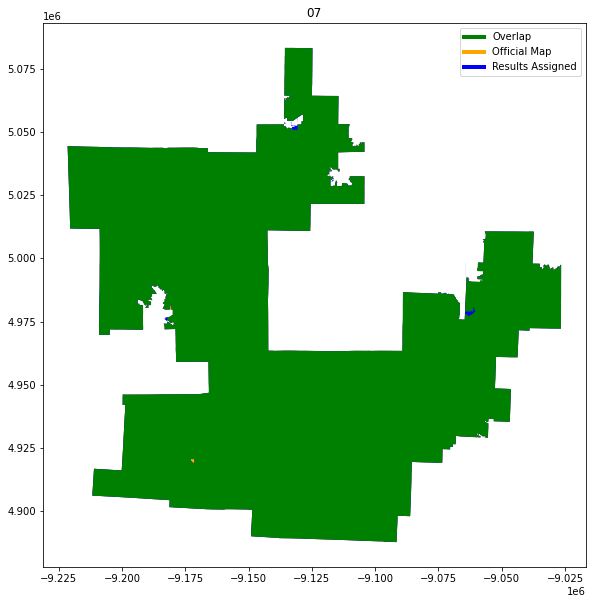

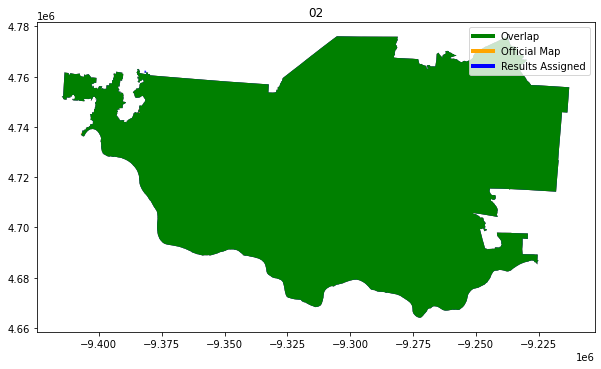

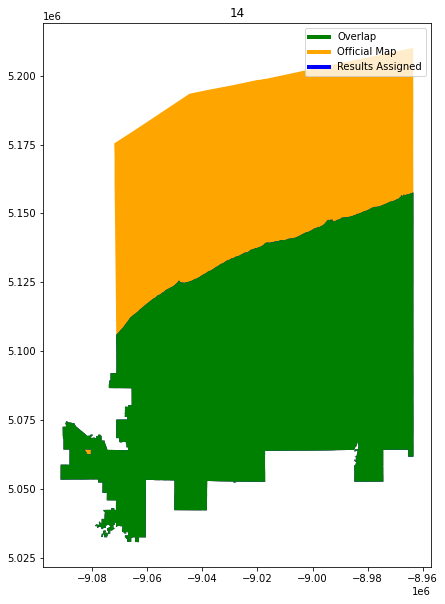

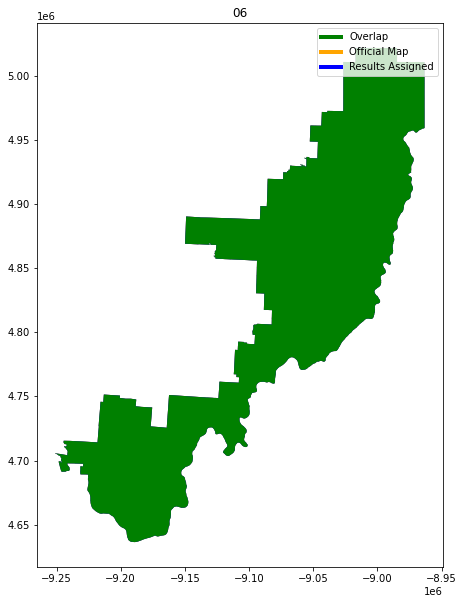

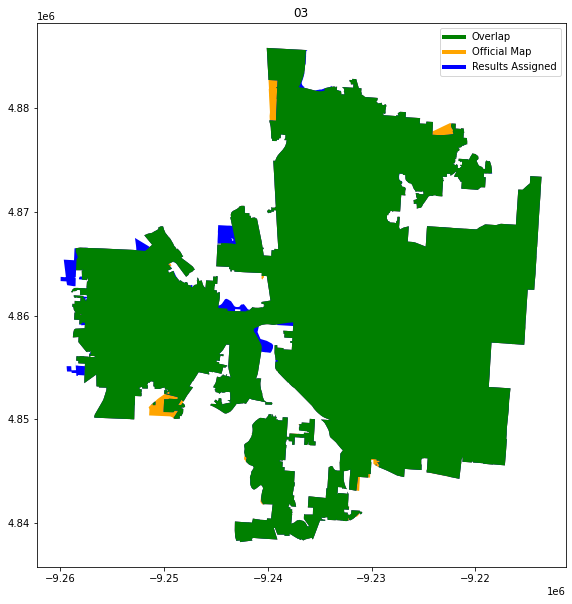

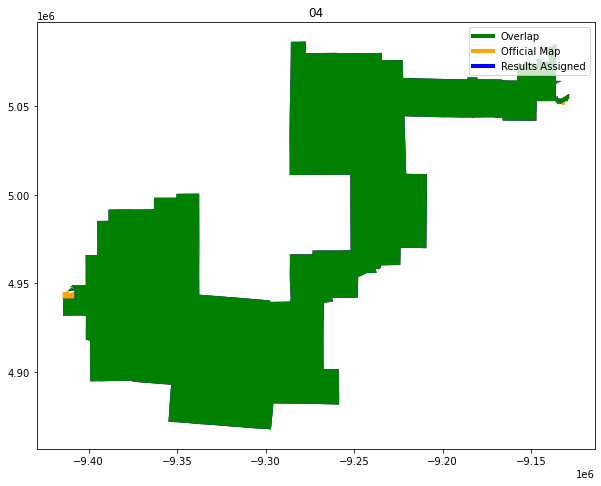

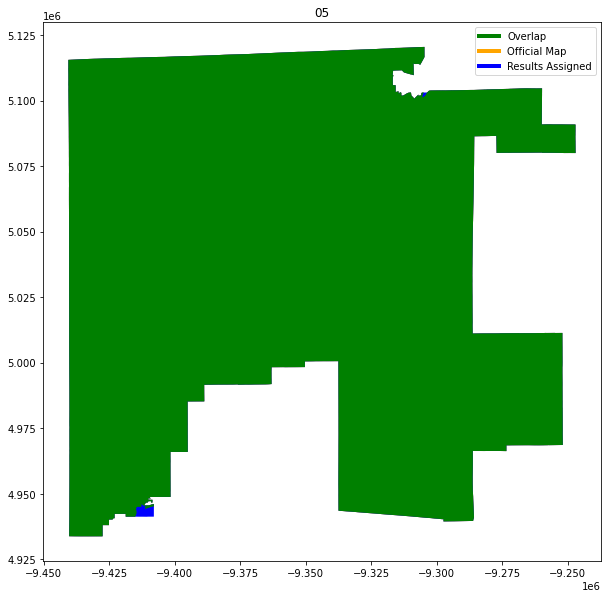

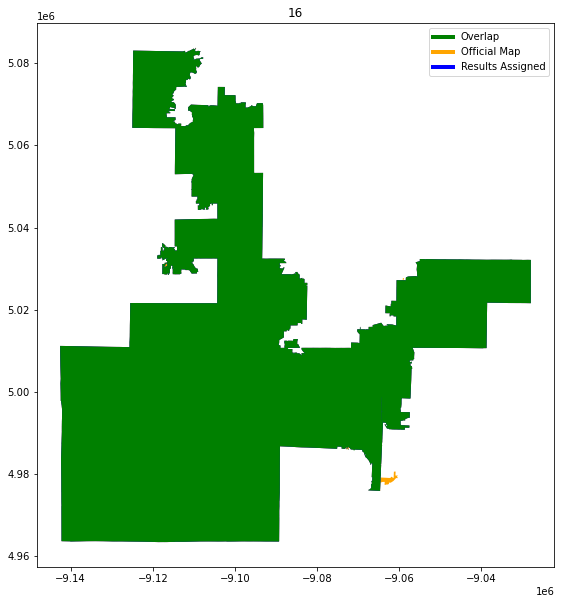

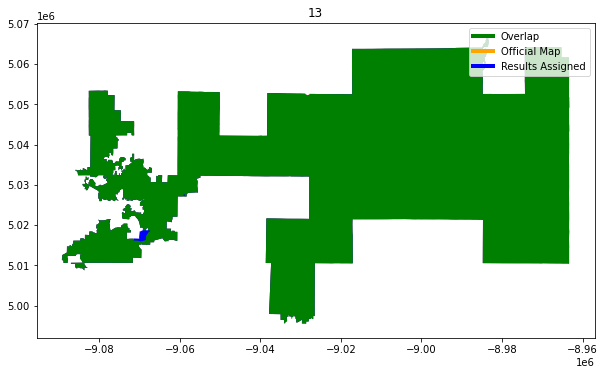

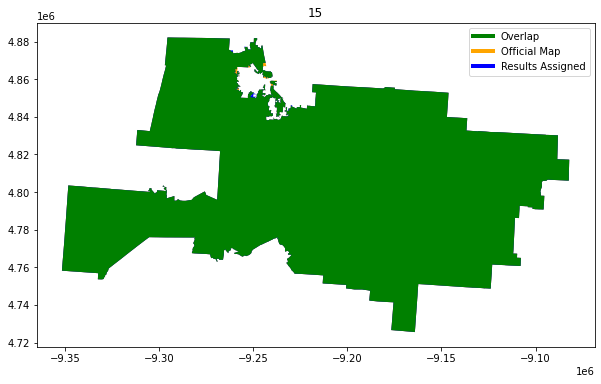

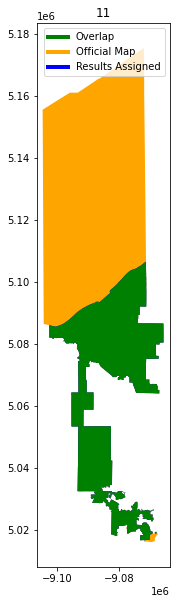

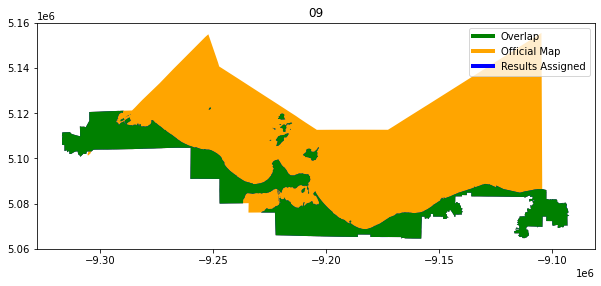

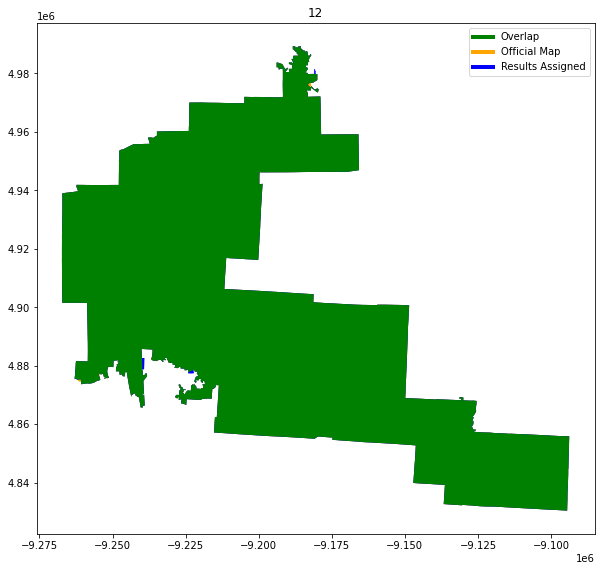

In [74]:
compare_geometries(oh_con_districts,filtered_results,"Official Map","Results Assigned","CONG_DIST",area_threshold=.1)

## Sort the columns to match what VEST has

In [75]:
vest_oh_20.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW', 'geometry',
       'UNIQUE_ID'],
      dtype='object')

In [76]:
attempt_one.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW', 'geometry',
       'UNIQUE_ID', 'County Name', 'Precinct Name', 'Precinct Code',
       'Region Name', 'Media Market', 'Registered Voters', 'COUNTYFP',
       'PCON01DFOS', 'PCON01DSCH', 'PCON02DCAS', 'PCON03DBEA', 'PCON03DHAR',
       'PCON04DFRE', 'PCON04DLAR', 'PCON04DSIT', 'PCON05DCAR', 'PCON05DRED',
       'PCON05DRUB', 'PCON06DROB', 'PCON08DENO', 'PCON08DGUY', 'PCON09DKAP',
       'PCON09DROS', 'PCON10DMOY', 'PCON10DTIM', 'PCON11DBEL', 'PCON11DFUD',
       'PCON11DHOO', 'PCON11DSHA', 'PCON12DBEL', 'PCON12DSHE', 'PCON13DRYA',
       'PCON14DMUE', 'PCON15DKIL', 'PCON15DNEW', 'PCON16DGOD', 'PCON16DKAR',
       'PCON01RCHA', 'PCON02RHAR', 'PCON02RWEN', 'PCON03RDUL', 'PCON03RRIC',
       'PCON04RJOR', 'PCON05RLAT', 'PCON06RJOH', 'PCON06RMOR', 'PCON07RGIB',
       'PCON08RDAV', 'PCON08RMEE', 'PCON09RBAR', 'PCON09RCON', 'PCON09RCOR',
       'PCON

In [77]:
attempt_one = attempt_one[["UNIQUE_ID","COUNTYFP",'STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20',
                           "CONG_DIST",'PCON01DFOS', 'PCON01DSCH', 'PCON02DCAS', 'PCON03DBEA', 'PCON03DHAR',
                           'PCON04DFRE', 'PCON04DLAR', 'PCON04DSIT', 'PCON05DCAR', 'PCON05DRED',
                           'PCON05DRUB', 'PCON06DROB', 'PCON08DENO', 'PCON08DGUY', 'PCON09DKAP',
                           'PCON09DROS', 'PCON10DMOY', 'PCON10DTIM', 'PCON11DBEL', 'PCON11DFUD',
                           'PCON11DHOO', 'PCON11DSHA', 'PCON12DBEL', 'PCON12DSHE', 'PCON13DRYA',
                           'PCON14DMUE', 'PCON15DKIL', 'PCON15DNEW', 'PCON16DGOD', 'PCON16DKAR',
                           'PCON01RCHA', 'PCON02RHAR', 'PCON02RWEN', 'PCON03RDUL', 'PCON03RRIC',
                           'PCON04RJOR', 'PCON05RLAT', 'PCON06RJOH', 'PCON06RMOR', 'PCON07RGIB',
                           'PCON08RDAV', 'PCON08RMEE', 'PCON09RBAR', 'PCON09RCON', 'PCON09RCOR',
                           'PCON09RWEB', 'PCON10RAND', 'PCON10RFLA', 'PCON10RTUR', 'PCON11RGOR',
                           'PCON11RSCH', 'PCON11RTAY', 'PCON12RBAL', 'PCON12RDAY', 'PCON13RHAG',
                           'PCON13RHEN', 'PCON13RLYR', 'PCON13RRMO', 'PCON13RJMO', 'PCON13RSAN',
                           'PCON13RTRU', 'PCON14RJOY', 'PCON14RPIT', 'PCON15RHUN', 'PCON15RSTI',
                           'PCON16RGON', 'PCON01LKAH', 'PCON04LPER', 'PCON07LLAP', 'PCON13LFRI', 
                          'geometry']]

In [78]:
if not os.path.exists('./oh_prim_20_prec/'):
    os.mkdir('./oh_prim_20_prec/')

attempt_one.to_file('./oh_prim_20_prec/oh_prim_20_cong_prec.shp')